In [1]:
import csv
import re
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
import warnings
from random import shuffle
from tqdm.notebook import tqdm



# Unsupervised Learning - STDP
## About this code:

In this code, we implement a Spiking Neural Network for sovling the XOR problem with ML eNeuron model. The used method is a bit different from 'XOR_rate_code_unsupervised_STDP_lateralWTA.ipynb' which is a visual representation of the code 'hyperparameter_architecture/unsupervised_classic_STDP.py'. There is no labelisation because there is only two neurons on the output layer. Hence a 100% accuracy to XOR problem would mean that one neuron spikes more than the other for only [0,0] and [1,1] binary input and so the other spikes faster for [0,1] and [1,0]; no matter which one.

However the architecture is different. This code utilises the architecture : [2,5,2]+wta. It means that there is two input neurons fully connected with 5 'hidden' neurons which are also fully connected to the output layer containing 2 neurons. It makes 20 excitatory synapses conducted by STDP rules. Plus, we had a lateral inhibition on the output layer and a retro_inhibition which means that the output neurons are fully connected to the hidden layer with inhibitory synapses.
It implies 12 inhibitatory synapses. Inhibition connection are ruled by constant weight.

 ! This method gives interesting results but it doesn't give 100% accuracy to XOR problem yet. It needs more research.

In [2]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()


# Simulation parameters
defaultclock.dt = 0.005*us  

n_train, n_test = 15,10

v_rest = -80*mV
v_threshold = 60*mV  
v_reset = -100*mV
v0 = -40*mV  
tau = 0.5*ms
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp
a_v = 1126.6343973469338
b_v = 169200.45773494235
x_threshold_v= 8.3e-11*amp
avoid_error = 0.01*pA
a_value = 6.23667974e13
refrac = 0*us

tau_stdp = 1.88116837
mag_stdp = 0.007070372048
time_sample = 100
time_resting = 20
alpha_decay = 1
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
avoid_error = 0.01*pA
c = 1

neuron_eqs_v1 = '''
dv/dt =  (v_rest - v) / tau2 + (( int((I + Ie+I_inhi) > x_threshold_v) *((a_v + b_v * log((1-int((I + Ie+I_inhi) > x_threshold_v))+int((I + Ie+I_inhi) > x_threshold_v)*(I+Ie+I_inhi+avoid_error)/(x_threshold_v) ))*I0)/a_value)*Rm) / tau : volt (unless refractory)
Ie =  activity*alpha_e*ge * uS *(80*mV -c*v)*inhi_factor           : amp
I_inhi =  activity*alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
inhi_factor : 1
activity :1
'''


V_a, V_b= 70*mV,90*mV
R_a = Rm*(V_a/mV)/(5/6)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_b = Rm*(V_b/mV)/(1/6)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b 
neuron_eqs_v3 = '''
dv/dt =  int((I + Ie+I_inhi) > x_threshold_v) *(v_rest - v) / tau2 + (( int((I + Ie+I_inhi) > x_threshold_v) *((a_v + b_v * log((1-int((I + Ie+I_inhi) > x_threshold_v))+int((I + Ie+I_inhi) > x_threshold_v)*(I+Ie+I_inhi+avoid_error)/(x_threshold_v) ))*I0)/a_value)*Rm) / tau : volt (unless refractory)
Ie =  activity*alpha_e*ge * uS *(80*mV -c*v)*inhi_factor           : amp
I_inhi =  activity*alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
inhi_factor : 1
Rm = (R_a)*int(v<(v_reset+V_a)) + (R_b)*int(v>=(v_reset+V_a)) : ohm
activity :1
'''



# Network

In [3]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

n_input = 2
input_group = NeuronGroup(n_input, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group.inhi_factor = 1
input_group.activity = 1


n_hidden = 5
hidden_group = NeuronGroup(n_hidden, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
hidden_group.inhi_factor = 1
hidden_group.activity = 1


n_output = 2
output_group = NeuronGroup(n_output, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
output_group.inhi_factor = 1
output_group.activity = 1



#STDP parameters
taupre = tau_stdp*us
taupost = taupre
wmax = 1
dApre = mag_stdp
dApost = -dApre * taupre / taupost * 1.05

stdp_eqs = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs='''
    ge_post += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, wmax)
'''
post_eqs='''
    Apost += dApost
    w = clip(w + lr*Apre, 0, wmax)
'''

synapse_model = "w : 1"


input_synapse = Synapses(input_group, hidden_group, model=stdp_eqs, on_pre=pre_eqs, on_post=post_eqs)
input_synapse.connect(True) # Fully connected
input_synapse.lr = 0.3
input_synapse.w = 'rand() * wmax*0.2'
input_synapse.delay = 'rand()*3*us'


hidden_synapse = Synapses(hidden_group, output_group, model=stdp_eqs, on_pre=pre_eqs, on_post=post_eqs)
hidden_synapse.connect(True) # Fully connected
hidden_synapse.lr = 1
hidden_synapse.w = 'rand() * wmax *0.5'
hidden_synapse.delay = 'rand()*0*us'

inhib_synapse = Synapses(output_group, output_group, model=synapse_model, on_pre='gi_post += w')
inhib_synapse.connect(condition='i != j') 
inhib_synapse.w = 'wmax * 0.9'
inhib_synapse.delay = 'rand()*0*us'

inhib2_synapse = Synapses(output_group, hidden_group, model=synapse_model, on_pre='gi_post += w')
#inhib2_synapse.connect(condition='i != j') 
inhib2_synapse.connect(True) 
inhib2_synapse.w = 'wmax *rand() * 1.3'
inhib2_synapse.delay = 'rand()*0*us'



M_input = StateMonitor(input_synapse, ['w'], record=True)
M_hidden = StateMonitor(hidden_synapse, ['w'], record=True)


# Monitors for input neurons
input_spike_monitor = SpikeMonitor(input_group)
input_state_monitor = StateMonitor(input_group, ['v', 'I'], record=True)

# Monitors for input neurons
hidden_spike_monitor = SpikeMonitor(hidden_group)
hidden_state_monitor = StateMonitor(hidden_group, ['v','Ie','I_inhi'], record=True)

# Monitors for output neuron
output_spike_monitor = SpikeMonitor(output_group)
output_state_monitor = StateMonitor(output_group, ['v','Ie','I_inhi'], record=True)


print("done")


done


In [4]:
input_group.v = v_reset
input_group.I = [2*nA,0.3*nA]
input_group.v = v_reset
hidden_group.v = v_reset
output_group.v = v_reset

# Run the simulation
defaultclock.dt = 0.005*us  
duration = time_sample*us
run(duration, report='text', report_period = 60*second)


output_group.activity = [1,1]
input_group.I = [0*nA,0*nA]
input_group.v = v_reset
hidden_group.v = v_reset
output_group.v = v_reset

# Run the simulation
duration = time_resting*us
run(duration, report='text', report_period = 60*second)

input_group.I = [2*nA,2*nA]
input_group.v = v_reset
hidden_group.v = v_reset
output_group.v = v_reset

# Run the simulation
duration = time_sample*us
run(duration, report='text', report_period = 60*second)


Starting simulation at t=0. s for a duration of 100. us
100. us (100%) simulated in 6s
Starting simulation at t=100. us for a duration of 20. us
20. us (100%) simulated in 1s
Starting simulation at t=120. us for a duration of 100. us
100. us (100%) simulated in 8s


# Input

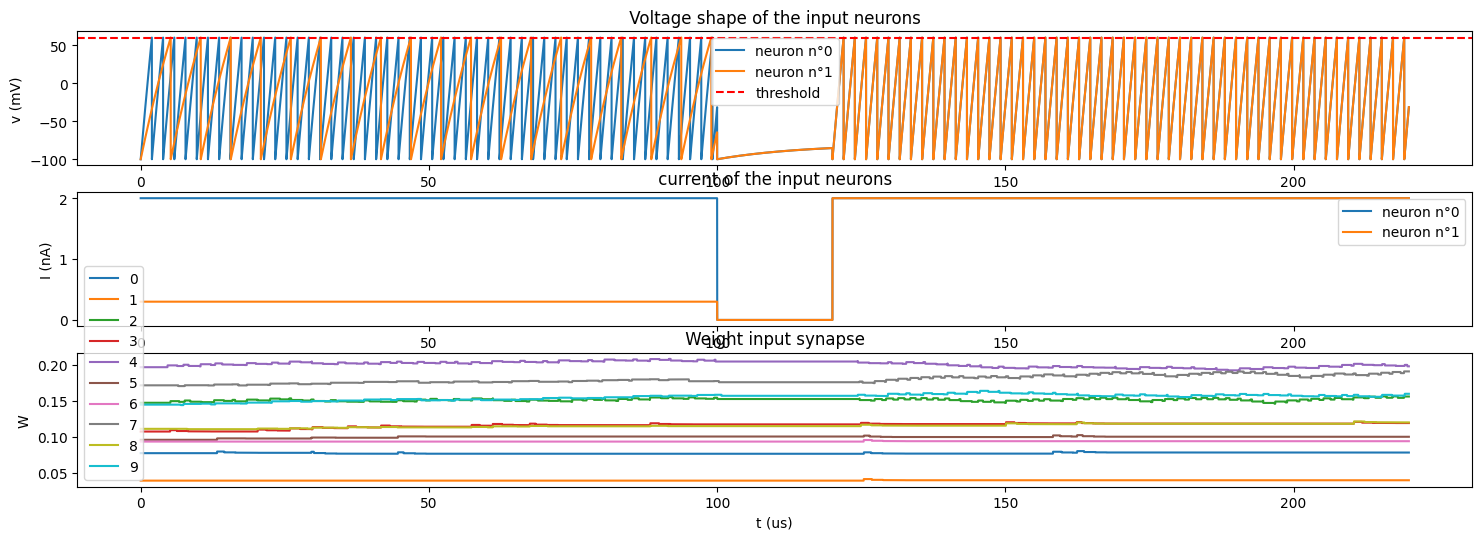

In [5]:
plt.figure(figsize=(18, 8))

plt.subplot(411)
plot(input_state_monitor.t/us, input_state_monitor[0].v/mV,label='neuron n°0')
plot(input_state_monitor.t/us, input_state_monitor[1].v/mV,label='neuron n°1')
plt.axhline(y=v_threshold/mV, color='r', linestyle='--',label='threshold')
plt.legend()
title(' Voltage shape of the input neurons ')
xlabel('t (us)')
ylabel('v (mV)')

plt.subplot(412)
plot(input_state_monitor.t/us, input_state_monitor[0].I/nA,label='neuron n°0')
plot(input_state_monitor.t/us, input_state_monitor[1].I/nA,label='neuron n°1')
plt.legend()
title(' current of the input neurons ')
xlabel('t (us)')
ylabel('I (nA)')


plt.subplot(413)
for i in range(n_input*n_hidden):
    plt.plot(M_input.t/us, M_input.w[i],label=f"{i}")
plt.legend()
title(' Weight input synapse ')
xlabel('t (us)')
ylabel('W')

plt.show()


# Hidden

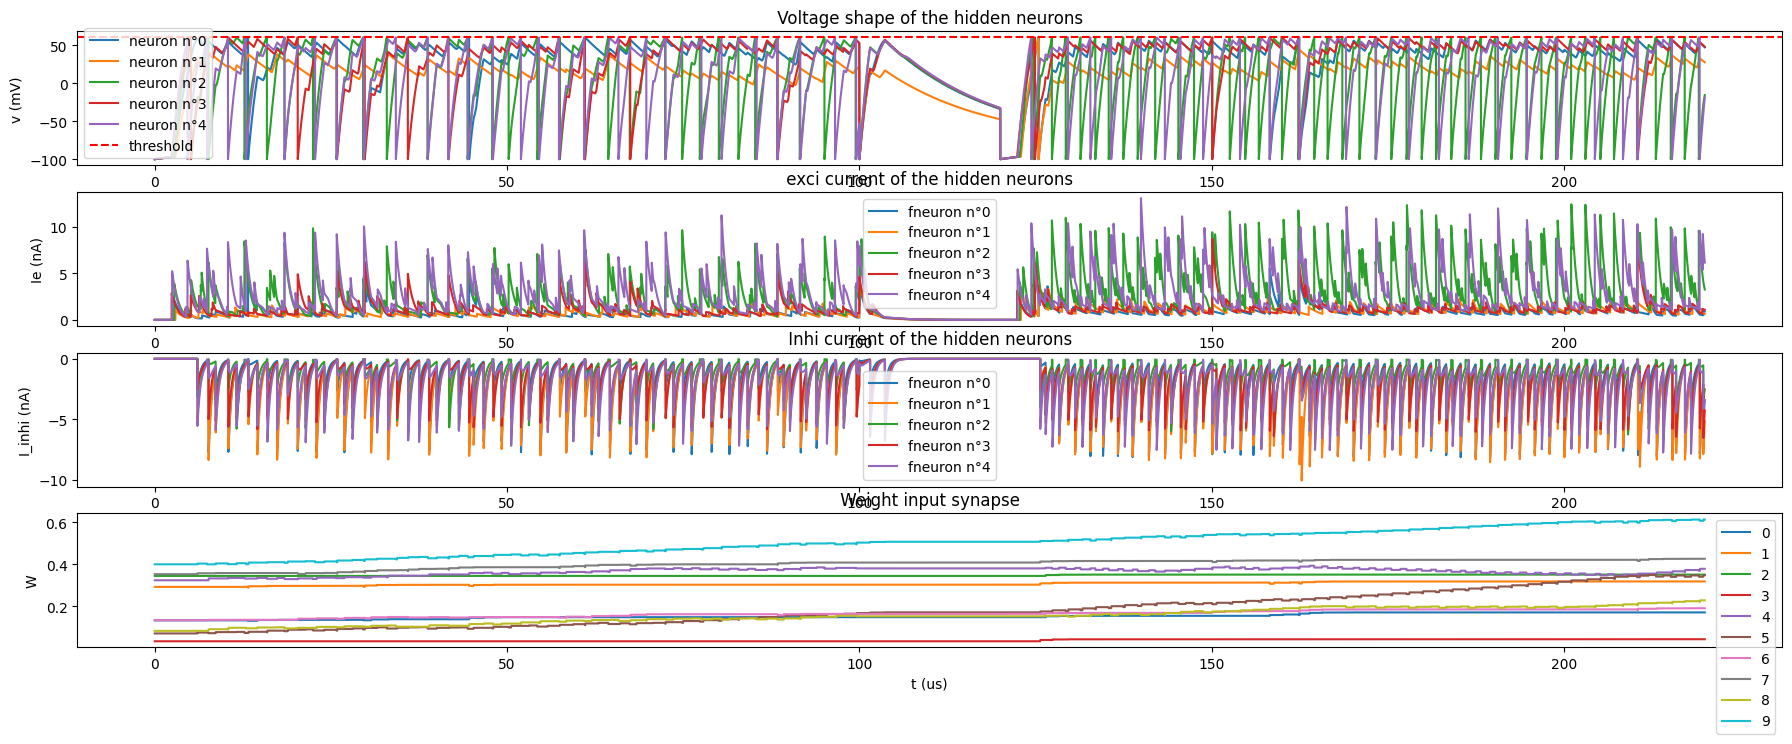

In [6]:
plt.figure(figsize=(22, 8))

plt.subplot(411)
for i in range(n_hidden):
    plot(hidden_state_monitor.t/us, hidden_state_monitor[i].v/mV,label=f'neuron n°{i}')
plt.axhline(y=v_threshold/mV, color='r', linestyle='--',label='threshold')
plt.legend()
title(' Voltage shape of the hidden neurons ')
xlabel('t (us)')
ylabel('v (mV)')

plt.subplot(412)
for i in range(n_hidden):
    plot(hidden_state_monitor.t/us, hidden_state_monitor[i].Ie/nA,label=f'fneuron n°{i}')
plt.legend()
title(' exci current of the hidden neurons ')
xlabel('t (us)')
ylabel('Ie (nA)')

plt.subplot(413)
for i in range(n_hidden):
    plot(hidden_state_monitor.t/us, hidden_state_monitor[i].I_inhi/nA,label=f'fneuron n°{i}')
plt.legend()
title(' Inhi current of the hidden neurons ')
xlabel('t (us)')
ylabel('I_inhi (nA)')


plt.subplot(414)
for i in range(n_output*n_hidden):
    plt.plot(M_hidden.t/us, M_hidden.w[i],label=f"{i}")
plt.legend()
title(' Weight input synapse ')
xlabel('t (us)')
ylabel('W')

plt.show()


# Output

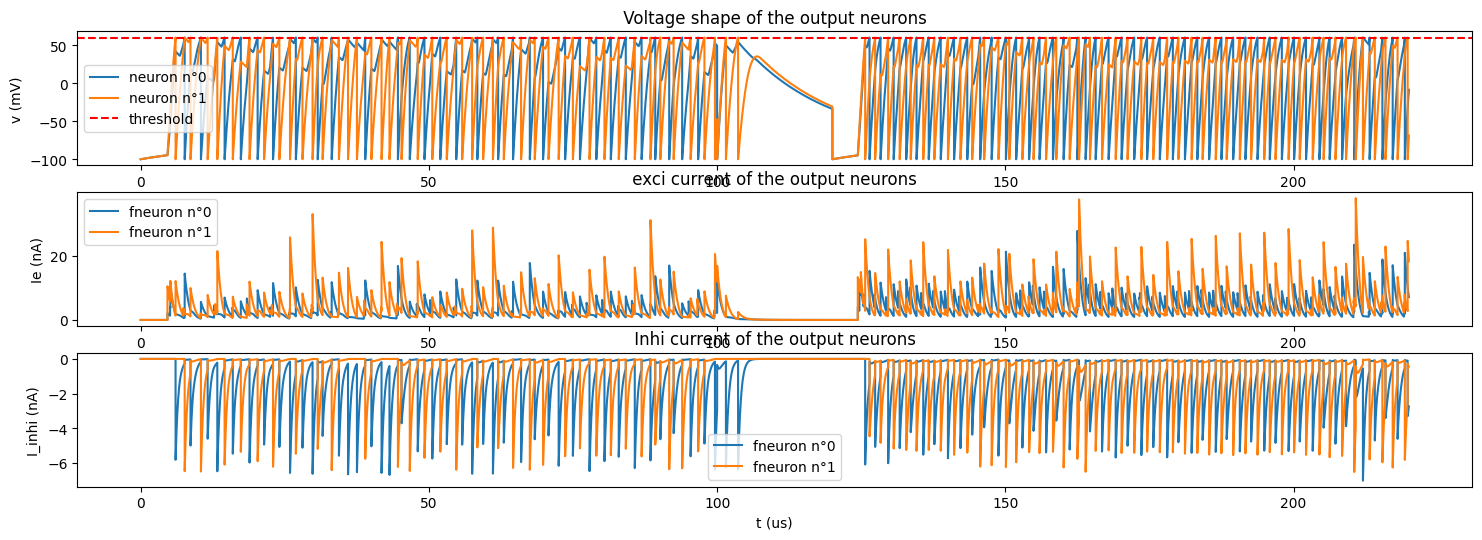

In [7]:
plt.figure(figsize=(18, 8))

plt.subplot(411)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].v/mV,label=f'neuron n°{i}')
plt.axhline(y=v_threshold/mV, color='r', linestyle='--',label='threshold')
plt.legend()
title(' Voltage shape of the output neurons ')
xlabel('t (us)')
ylabel('v (mV)')

plt.subplot(412)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].Ie/nA,label=f'fneuron n°{i}')
plt.legend()
title(' exci current of the output neurons ')
xlabel('t (us)')
ylabel('Ie (nA)')

plt.subplot(413)
for i in range(n_output):
    plot(output_state_monitor.t/us, output_state_monitor[i].I_inhi/nA,label=f'fneuron n°{i}')
plt.legend()
title(' Inhi current of the output neurons ')
xlabel('t (us)')
ylabel('I_inhi (nA)')

plt.show()


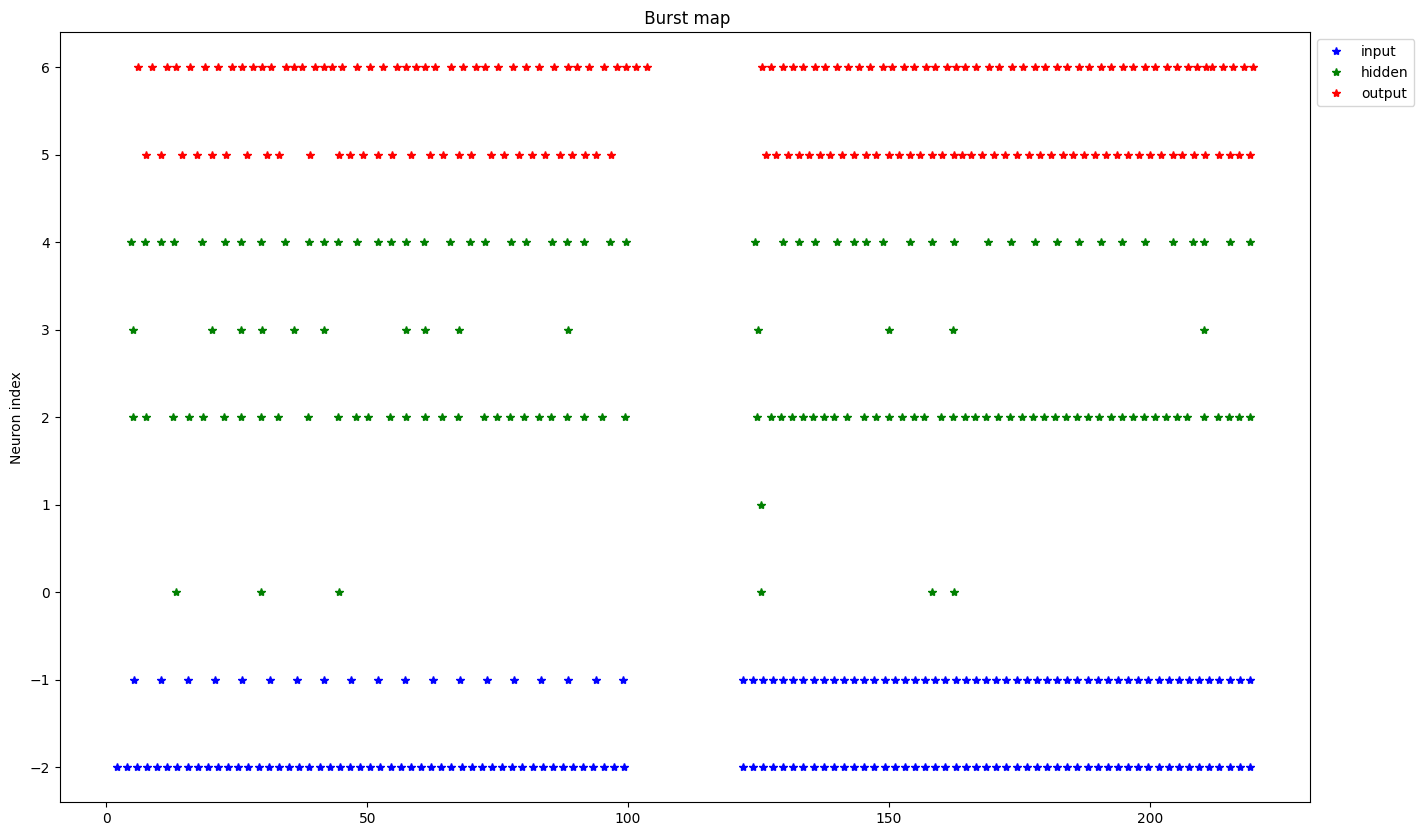

In [8]:
plt.figure(figsize=(20, 10))
plot(input_spike_monitor.t/us, input_spike_monitor.i+np.array([-n_input for i in range(len(input_spike_monitor.i))]), '*b',label='input')
plot(hidden_spike_monitor.t/us, hidden_spike_monitor.i, '*g',label='hidden')
plot(output_spike_monitor.t/us, output_spike_monitor.i+np.array([n_hidden for i in range(len(output_spike_monitor.i))]), '*r',label='output')
plt.ylabel('Neuron index')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.75)
plt.title(" Burst map")
plt.show()

## Creating XOR Data 


In [9]:
X_train = n_train*[[0,0]] + n_train*[[0,1]] + n_train*[[1,0]] + n_train*[[1,1]]
shuffle(X_train)
y_train = [a ^ b for a, b in X_train]


X_test = n_test*[[0,0]] + n_test*[[0,1]] + n_test*[[1,0]] + n_test*[[1,1]]
shuffle(X_test)
y_test = [a ^ b for a, b in X_test]


def from_bit_to_current(x):
    if x == [0,0]:
        return [0.3,0.3]
    elif x == [0,1]:
        return [0.3,2]
    elif x == [1,0]:
        return [2,0.3]
    elif x == [1,1]:
        return [2,2]
    else:
        print(" WARNING PROBLEM !")
        
def from_bit_to_label(x):
    if x == [0,0]:
        return 0
    elif x == [0,1]:
        return 1
    elif x == [1,0]:
        return 2
    elif x == [1,1]:
        return 3
    else:
        print(" WARNING PROBLEM !")
        


# Training Part

In [10]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()


input_group = NeuronGroup(n_input, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group.inhi_factor = 1
input_group.activity = 1

hidden_group = NeuronGroup(n_hidden, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
hidden_group.inhi_factor = 1
hidden_group.activity = 1

output_group = NeuronGroup(n_output, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
output_group.inhi_factor = 1
output_group.activity = 1


input_synapse = Synapses(input_group, hidden_group, model=stdp_eqs, on_pre=pre_eqs, on_post=post_eqs)
input_synapse.connect(True) # Fully connected
input_synapse.lr = 0.3
input_synapse.w = 'rand() * wmax * 0.2'
input_synapse.delay = 'rand()*0*us'


hidden_synapse = Synapses(hidden_group, output_group, model=stdp_eqs, on_pre=pre_eqs, on_post=post_eqs)
hidden_synapse.connect(True) # Fully connected
hidden_synapse.lr = 1
hidden_synapse.w = 'rand() * wmax * 0.5'
hidden_synapse.delay = 'rand()*0*us'


inhib_synapse = Synapses(output_group, output_group, model=synapse_model, on_pre='gi_post += w')
inhib_synapse.connect(condition='i != j') 
inhib_synapse.w = 'wmax * 0.5'
inhib_synapse.delay = 'rand()*0*us'

inhib2_synapse = Synapses(output_group, hidden_group, model=synapse_model, on_pre='gi_post += w')
#inhib2_synapse.connect(condition='i != j') 
inhib2_synapse.connect(True) 
inhib2_synapse.w = 'wmax *rand() * 0.9'
inhib2_synapse.delay = 'rand()*0*us'


# Monitors for input neurons
input_spike_monitor = SpikeMonitor(input_group)

# Monitors for input neurons
hidden_spike_monitor = SpikeMonitor(hidden_group)

# Monitors for output neurons
output_spike_monitor = SpikeMonitor(output_group)


print("done")


WARNING    'i' is an internal variable of group 'synapses_6', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


done


In [11]:

time_per_sample = time_sample * us
resting_time = time_resting * us
input_group.v = v_reset
hidden_group.v = v_reset
output_group.v = v_reset

# Create the network
net = Network(input_group, hidden_group, output_group, 
              input_synapse, hidden_synapse,inhib_synapse,inhib2_synapse,
              input_spike_monitor,hidden_spike_monitor,output_spike_monitor,
             )

print(output_spike_monitor.count)

<spikemonitor_1.count: array([0, 0])>


  0%|          | 0/60 [00:00<?, ?it/s]

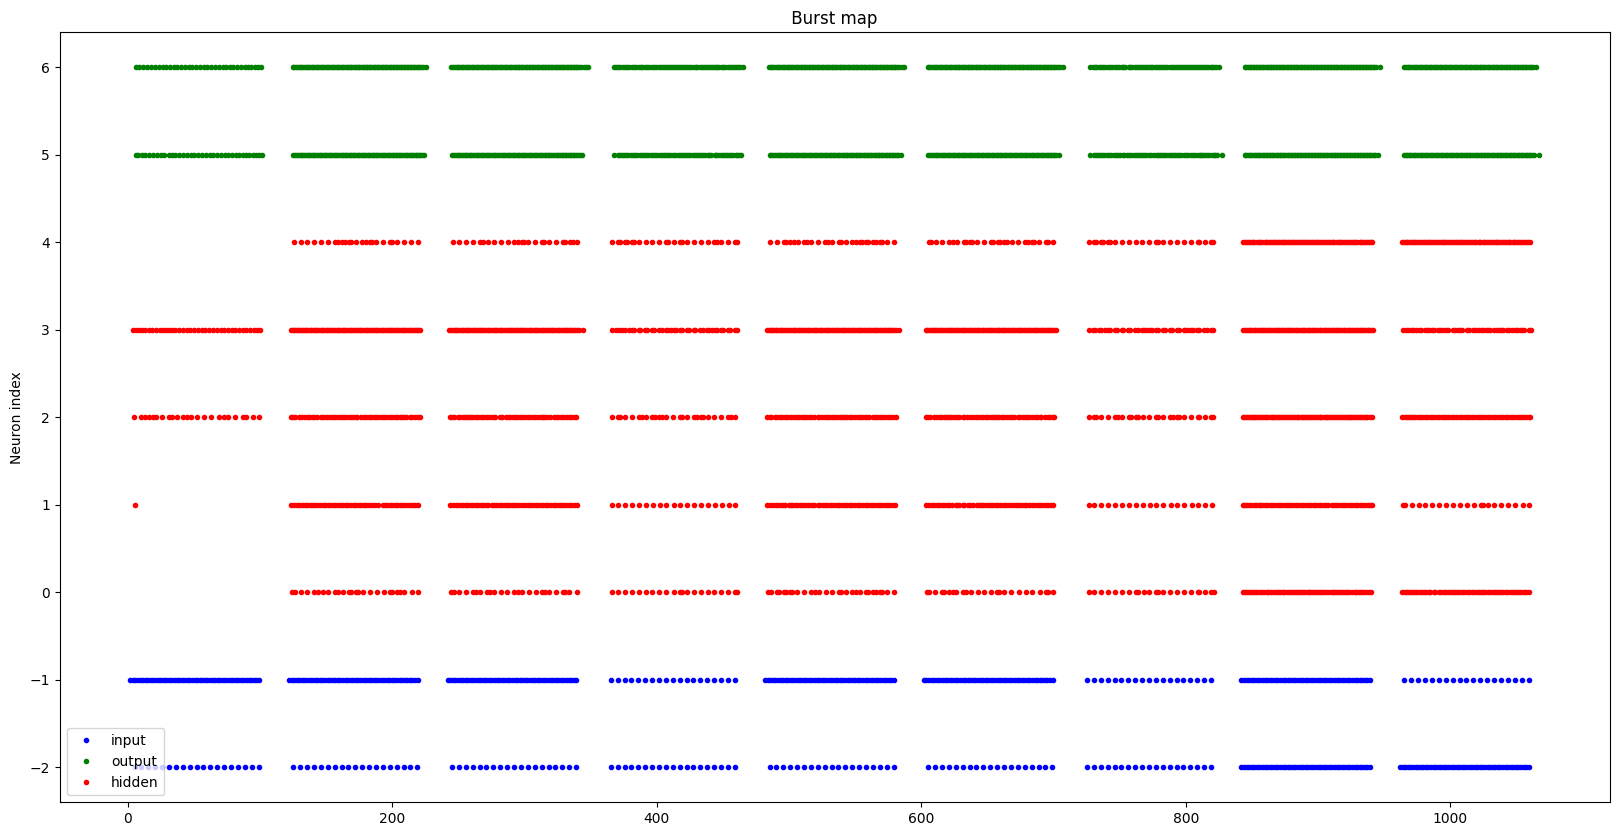

It has taken  378.451180934906 s to run for the epoch 


In [12]:
# Training session 

weight_evol_input = []
weight_evol_hidden = []

frequency_evolution_n0 = [[],[],[],[]]
frequency_evolution_n1 = [[],[],[],[]]

time_evolution_n0 = [[],[],[],[]]
time_evolution_n1 = [[],[],[],[]]



spikes = np.zeros((4, n_output))
old_spike_counts = np.zeros(n_output)
old_spike_counts = np.copy(output_spike_monitor.count)

old_time_spikes = np.zeros(0)

standon = 1
tic = time.time()
for j, (sample, label) in enumerate(tqdm(zip(X_train, y_train), total=len(X_train))):


    # Start the simulation
    input_group.I = from_bit_to_current(sample) * nA
    net.run(time_per_sample)
    
    counter_spike = output_spike_monitor.count - old_spike_counts
    spikes[from_bit_to_label(sample)] += counter_spike
    old_spike_counts = np.copy(output_spike_monitor.count)
    
    rank_spike = np.copy(output_spike_monitor.i[len(old_time_spikes):])
    time_spike = np.copy(output_spike_monitor.t[len(old_time_spikes):])
    
    # A draft code to observe the time of the first spike per neuron.
    if rank_spike[0] == 0:
        time_evolution_n0[from_bit_to_label(sample)].append(time_spike[0])
        while rank_spike[0] != 1 and standon == 1:
            standon = 1
            rank_spike = rank_spike[1:]
            time_spike = time_spike[1:]
            if len(rank_spike) == 1:
                time_evolution_n1[from_bit_to_label(sample)].append(0)
                standon = 0
        time_evolution_n1[from_bit_to_label(sample)].append(time_spike[0])
        
    elif rank_spike[0] == 1:
        time_evolution_n1[from_bit_to_label(sample)].append(time_spike[0])
        while rank_spike[0] != 0 and standon == 1:
            standon = 1
            rank_spike = rank_spike[1:]
            time_spike = time_spike[1:]
            if len(rank_spike) == 1:
                time_evolution_n0[from_bit_to_label(sample)].append(0)
                standon = 0
        time_evolution_n0[from_bit_to_label(sample)].append(time_spike[0])
    
    frequency_evolution_n0[from_bit_to_label(sample)].append(counter_spike[0]/time_per_sample)
    frequency_evolution_n1[from_bit_to_label(sample)].append(counter_spike[1]/time_per_sample)
       

    # Allow the variables to return to their resting values
    input_group.I = 0 * nA
    net.run(resting_time) 
    input_group.v = v_reset
    hidden_group.v = v_reset
    output_group.v = v_reset
    
    old_spike_counts = np.copy(output_spike_monitor.count)
    old_time_spikes = np.copy(output_spike_monitor.i)

    # Plot a burst map
    if j >= 8 and j<9:
        plt.figure(figsize=(20, 10)) 
        plot(input_spike_monitor.t/us, input_spike_monitor.i+np.array([-n_input for i in range(len(input_spike_monitor.i))]), '.b',label='input')
        plot(output_spike_monitor.t/us, output_spike_monitor.i+np.array([n_hidden for i in range(len(output_spike_monitor.i))]), '.g',label='output')
        plot(hidden_spike_monitor.t/us, hidden_spike_monitor.i, '.r',label='hidden')
        plt.ylabel('Neuron index')
        plt.legend()
        plt.title(" Burst map ")
        plt.show()
        
        
    #NORMALISATION :
    weight_matrix = np.zeros([n_input, n_hidden])
    weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w
    sumCol = np.sum(weight_matrix, axis=0)
    colFactors = 1/sumCol
    for jj in range(n_hidden):
        weight_matrix[:,jj] *= colFactors[jj]
    input_synapse.w = weight_matrix[input_synapse.i, input_synapse.j]

    weight_matrix = np.zeros([n_hidden, n_output])
    weight_matrix[hidden_synapse.i, hidden_synapse.j] = hidden_synapse.w
    sumCol = np.sum(weight_matrix, axis=0)
    colFactors = 1/sumCol
    for jj in range(n_output):
        weight_matrix[:,jj] *= colFactors[jj]
    hidden_synapse.w = weight_matrix[hidden_synapse.i, hidden_synapse.j]
    
    # Observation weight evolution
    weight = [input_synapse.w[i] for i in range(len(input_synapse.w))]
    weight_evol_input.append(weight)
    weight = [hidden_synapse.w[i] for i in range(len(hidden_synapse.w))]
    weight_evol_hidden.append(weight)



tac = time.time()
print("It has taken ", tac-tic,"s to run for the epoch ")
            

## Visualising the total number of spike per output neuron 

Because there is no labelisation, what we want to see is one neuron spiking more than the other for only [0,0] and [1,1] binary input and so the other spikes faster for [0,1] and [1,0]; no matter which one.

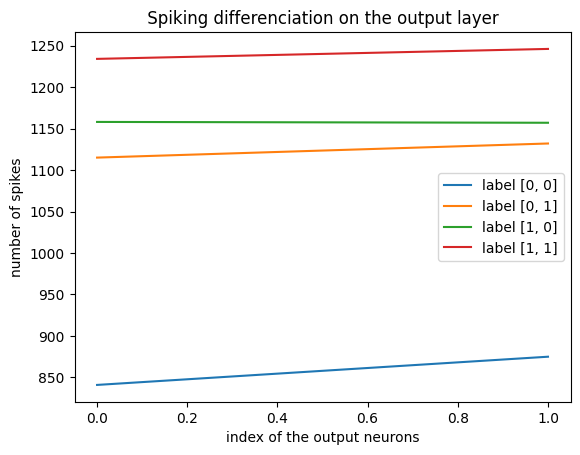

In [13]:
label_list = [[0,0],[0,1],[1,0],[1,1]]


for i in range(len(spikes)):
    if spikes[i].any() != np.zeros(len(spikes[i])).any():
        plt.plot(range(len(spikes[i])),spikes[i], label=f'label {label_list[i]}')
        
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.title(" Spiking differenciation on the output layer ")
plt.legend()
plt.show()

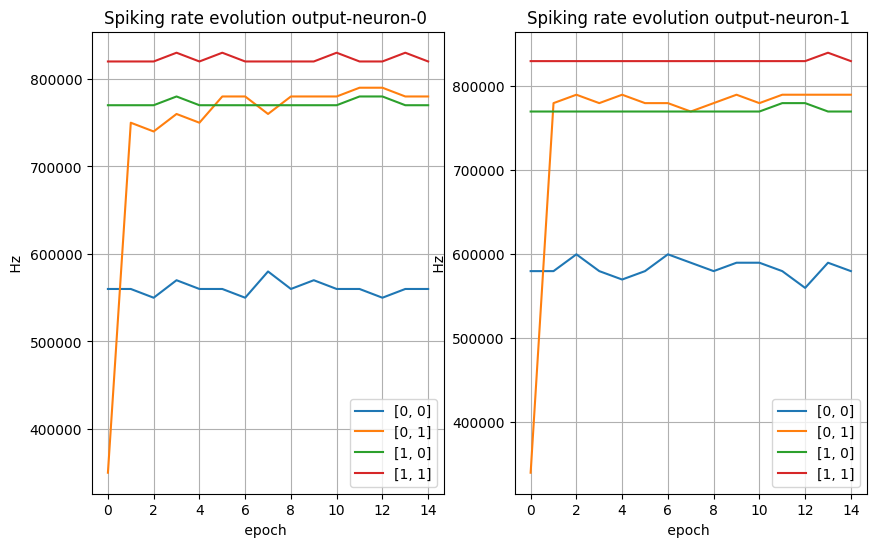

In [14]:

plt.figure(figsize=(10, 6)) 

label_list = [[0,0],[0,1],[1,0],[1,1]]
plt.subplot(1, 2, 1)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n0[i])), frequency_evolution_n0[i], label=f'{label}') 

plt.title('Spiking rate evolution output-neuron-0 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n1[i])), frequency_evolution_n1[i], label=f'{label}')  

plt.title('Spiking rate evolution output-neuron-1 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.show()


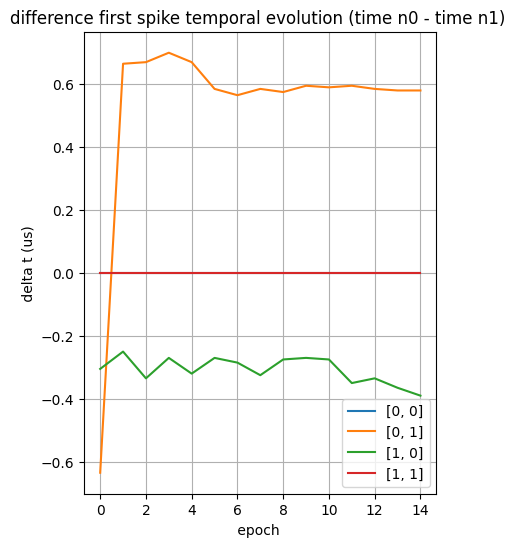

In [15]:

plt.figure(figsize=(10, 6)) 

label_list = [[0,0],[0,1],[1,0],[1,1]]
plt.subplot(1, 2, 1)  
for i,label in enumerate(label_list):
    subraste_time = [(i-j)*1e6 for (i,j) in zip(time_evolution_n0[i],time_evolution_n1[i])]
    plt.plot(range(len(time_evolution_n0[i])), subraste_time, label=f'{label}')  

plt.title('difference first spike temporal evolution (time n0 - time n1) ')
plt.xlabel(f' epoch  ')
plt.ylabel(' delta t (us) ')
plt.grid(True)
plt.legend()




## Weight visualisation

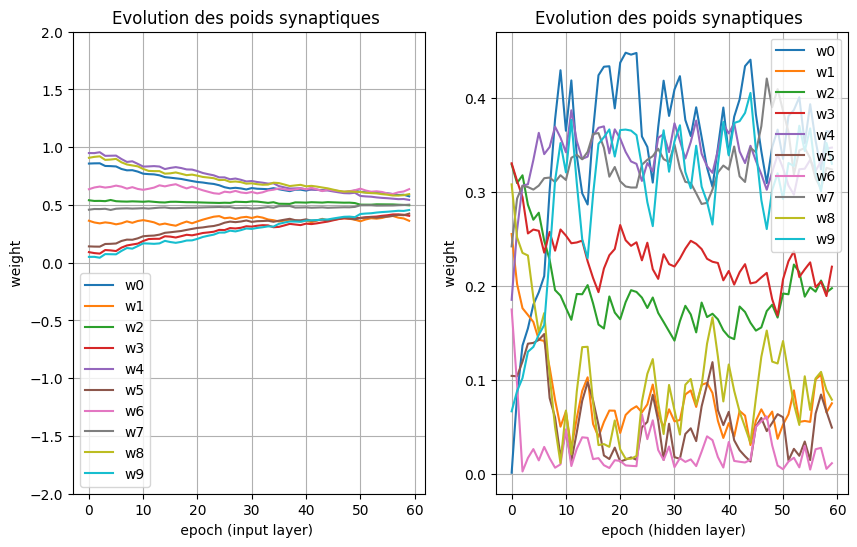

In [16]:

plt.figure(figsize=(10, 6)) 

plt.subplot(1, 2, 1)  
for idx_w in range(len(weight_evol_input[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_input]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques ')
plt.xlabel(f' epoch (input layer)  ')
plt.ylabel(' weight ')
plt.ylim(-wmax-1, wmax+1) 
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)  
for idx_w in range(len(weight_evol_hidden[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_hidden]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques ')
plt.xlabel(f' epoch (hidden layer)')
plt.ylabel(' weight ')
plt.grid(True)
plt.legend()



plt.show()


# Evaluation

In [17]:
input_group.v = v_reset
hidden_group.v = v_reset
output_group.v = v_reset

#Desactivate STDP :
input_synapse.lr = 0
hidden_synapse.lr = 0



weight_evol_input = []
weight_evol_hidden = []

frequency_evolution_n0 = [[],[],[],[]]
frequency_evolution_n1 = [[],[],[],[]]

time_evolution_n0 = [[],[],[],[]]
time_evolution_n1 = [[],[],[],[]]


spikes = np.zeros((4, n_output))
old_spike_counts = np.zeros(n_output)
old_spike_counts = np.copy(output_spike_monitor.count)

old_time_spikes = np.zeros(0)

tic = time.time()
for j, (sample, label) in enumerate(tqdm(zip(X_test, y_test), total=len(y_test))):


    input_group.I = from_bit_to_current(sample) * nA

    # Start the simulation
    net.run(time_per_sample)
    
    counter_spike = output_spike_monitor.count - old_spike_counts
    spikes[from_bit_to_label(sample)] += counter_spike
    old_spike_counts = np.copy(output_spike_monitor.count)
    
    rank_spike = np.copy(output_spike_monitor.i[len(old_time_spikes):])
    time_spike = np.copy(output_spike_monitor.t[len(old_time_spikes):])
    
    # A draft code to observe the time of the first spike per neuron.
    if rank_spike[0] == 0:
        time_evolution_n0[from_bit_to_label(sample)].append(time_spike[0])
        while rank_spike[0] != 1 and standon == 1:
            standon = 1
            rank_spike = rank_spike[1:]
            time_spike = time_spike[1:]
            if len(rank_spike) == 1:
                time_evolution_n1[from_bit_to_label(sample)].append(0)
                standon = 0
        time_evolution_n1[from_bit_to_label(sample)].append(time_spike[0])
        
    elif rank_spike[0] == 1:
        time_evolution_n1[from_bit_to_label(sample)].append(time_spike[0])
        while rank_spike[0] != 0 and standon == 1:
            standon = 1
            rank_spike = rank_spike[1:]
            time_spike = time_spike[1:]
            if len(rank_spike) == 1:
                time_evolution_n0[from_bit_to_label(sample)].append(0)
                standon = 0
        time_evolution_n0[from_bit_to_label(sample)].append(time_spike[0])
        
    frequency_evolution_n0[from_bit_to_label(sample)].append(counter_spike[0]/time_per_sample)
    frequency_evolution_n1[from_bit_to_label(sample)].append(counter_spike[1]/time_per_sample)
    
   
    # Allow the variables to return to their resting values
    input_group.I = 0 * nA
    net.run(resting_time) 
    input_group.v = v_reset
    hidden_group.v = v_reset
    output_group.v = v_reset
    old_spike_counts = np.copy(output_spike_monitor.count)
    old_time_spikes = np.copy(output_spike_monitor.i)
        
    # Observe weight evolution
    weight = [input_synapse.w[i] for i in range(len(input_synapse.w))]
    weight_evol_input.append(weight)
    weight = [hidden_synapse.w[i] for i in range(len(hidden_synapse.w))]
    weight_evol_hidden.append(weight)



tac = time.time()
print("It has taken ", tac-tic,"s to run for the epoch ")
            

  0%|          | 0/40 [00:00<?, ?it/s]

It has taken  331.64398193359375 s to run for the epoch 


## Visualising the total number of spike per output neuron 

Because there is no labelisation, what we want to see is one neuron spiking more than the other for only [0,0] and [1,1] binary input and so the other spikes faster for [0,1] and [1,0]; no matter which one.

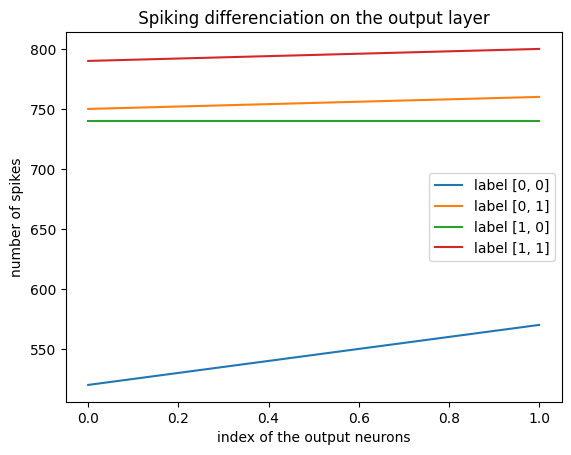

In [18]:
label_list = [[0,0],[0,1],[1,0],[1,1]]


for i in range(len(spikes)):
    if spikes[i].any() != np.zeros(len(spikes[i])).any():
        plt.plot(range(len(spikes[i])),spikes[i], label=f'label {label_list[i]}')
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.title(" Spiking differenciation on the output layer ")
plt.legend()
plt.show()

### Observing which neuron spikes the more for each input.

[[520. 570.]
 [750. 760.]
 [740. 740.]
 [790. 800.]]


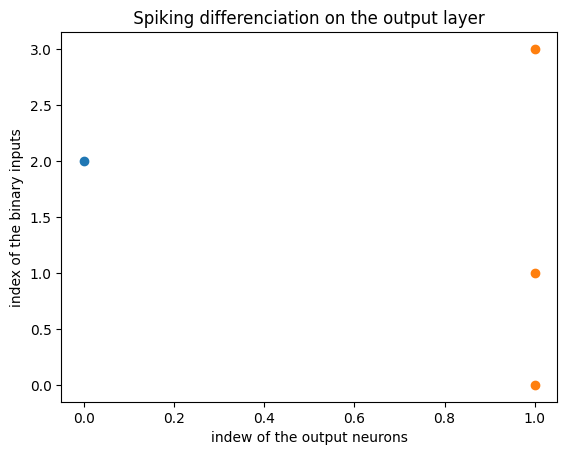

In [19]:
labeled_neurons = [[],[]]

print(spikes)
for i,spike in enumerate(spikes):
    idx = np.argmax(spike)
    labeled_neurons[idx].append(i)
plt.scatter([0 for i in range(len(labeled_neurons[0]))],labeled_neurons[0])
plt.scatter([1 for i in range(len(labeled_neurons[1]))],labeled_neurons[1])
plt.ylabel('index of the binary inputs')
plt.xlabel('indew of the output neurons')
plt.title(" Spiking differenciation on the output layer ")
plt.show()
    

## Observing the Spiking rate evolution

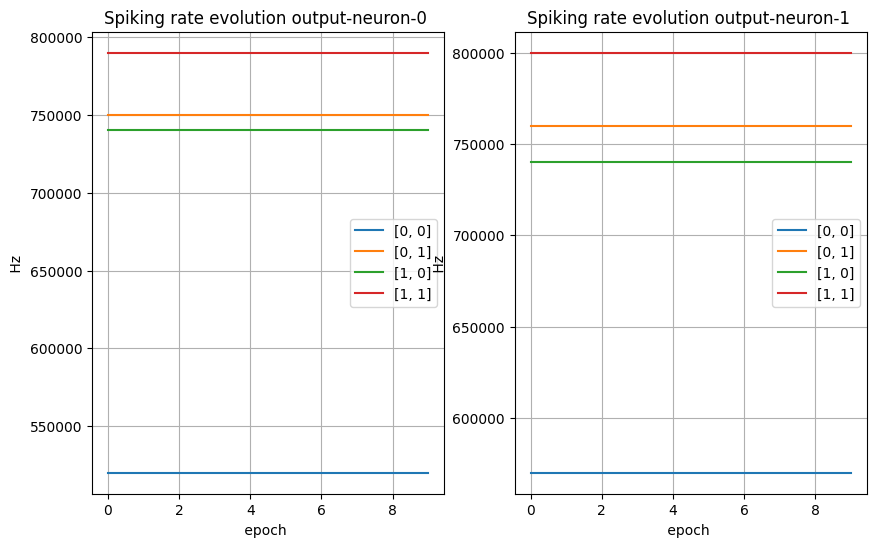

In [20]:

plt.figure(figsize=(10, 6)) 

label_list = [[0,0],[0,1],[1,0],[1,1]]
plt.subplot(1, 2, 1)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n0[i])), frequency_evolution_n0[i], label=f'{label}')  

plt.title('Spiking rate evolution output-neuron-0 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n1[i])), frequency_evolution_n1[i], label=f'{label}')  

plt.title('Spiking rate evolution output-neuron-1 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.show()


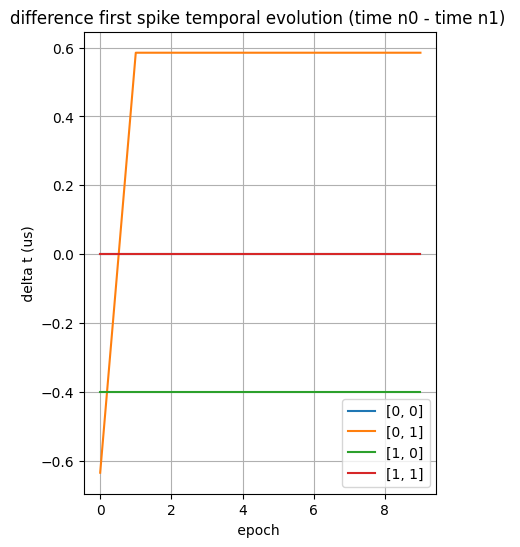

In [21]:

plt.figure(figsize=(10, 6)) 

label_list = [[0,0],[0,1],[1,0],[1,1]]
plt.subplot(1, 2, 1)  
for i,label in enumerate(label_list):
    subraste_time = [(i-j)*1e6 for (i,j) in zip(time_evolution_n0[i],time_evolution_n1[i])]
    plt.plot(range(len(time_evolution_n0[i])), subraste_time, label=f'{label}')  

plt.title('difference first spike temporal evolution (time n0 - time n1) ')
plt.xlabel(f' epoch  ')
plt.ylabel(' delta t (us) ')
plt.grid(True)
plt.legend()




## Weight check

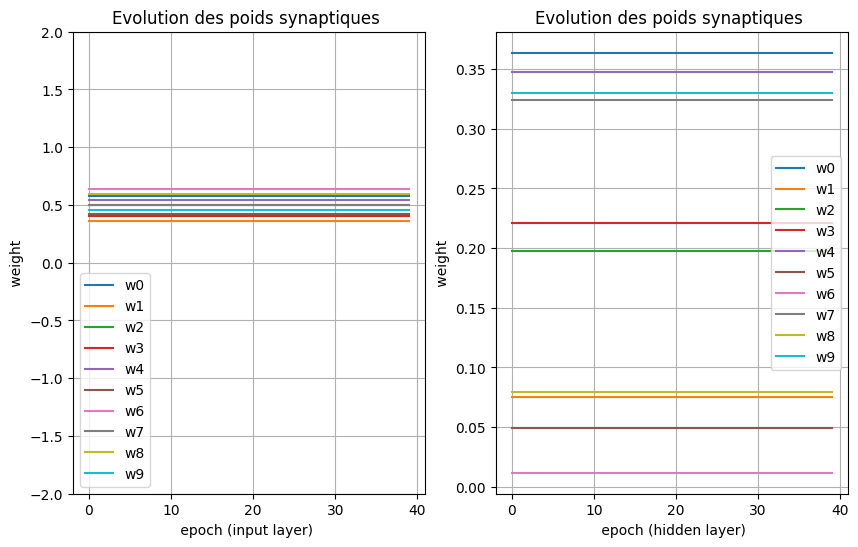

In [22]:
plt.figure(figsize=(10, 6)) 

plt.subplot(1, 2, 1)  
for idx_w in range(len(weight_evol_input[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_input]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques ')
plt.xlabel(f' epoch (input layer)  ')
plt.ylabel(' weight ')
plt.ylim(-wmax-1, wmax+1) 
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)  
for idx_w in range(len(weight_evol_hidden[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_hidden]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques ')
plt.xlabel(f' epoch (hidden layer)')
plt.ylabel(' weight ')
plt.grid(True)
plt.legend()



plt.show()
